Based on 
- https://llava-vl.github.io/
- https://github.com/LLaVA-VL/LLaVA-NeXT/

In [1]:
import os
import subprocess
from projectaria_tools.projects.aea import (
    AriaEverydayActivitiesDataPathsProvider,
    AriaEverydayActivitiesDataProvider)
import numpy as np

import matplotlib.pyplot as plt

from projectaria_tools.core import calibration, mps
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.mps import get_eyegaze_point_at_depth

from projectaria_tools.core.sophus import SE3
from projectaria_tools.core.stream_id import StreamId

from segment_anything import sam_model_registry, SamPredictor
import cv2
import tqdm

# VLM part
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from PIL import Image
import torch

In [5]:
device = "cuda:0"

In [6]:
#llava model
def load_llava_model(model_name, device="cuda:0"):
    model = LlavaNextForConditionalGeneration.from_pretrained(model_name, dtype=torch.float16)
    processor = LlavaNextProcessor.from_pretrained(model_name)
    return model.to(device), processor

model, processor = load_llava_model("llava-hf/llava-v1.6-vicuna-7b-hf", device)
print(model.device)
 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda:0


In [7]:
sequence_name_rec1 = "loc1_script1_seq1_rec1"
sequence_path_rec1 = "./" + sequence_name_rec1

# create AEA data provider
aea_data_provider_1 = AriaEverydayActivitiesDataProvider(sequence_path_rec1)

RGB_STREAM_ID = StreamId("214-1")

device_time_vec_1 = aea_data_provider_1.vrs.get_timestamps_ns(RGB_STREAM_ID, TimeDomain.DEVICE_TIME)

device_time_ns_1 = device_time_vec_1[100]

sentence = aea_data_provider_1.speech.get_sentence_data_by_timestamp_ns(
    device_time_ns_1, TimeQueryOptions.CLOSEST
)
print(f"Sentence from sequence 1 at device timestamp {device_time_ns_1} is : '{sentence}'")

Sentence from sequence 1 at device timestamp 61385219700 is : 'and what is there like looking at?'


[MpsDataPathsProvider][WARNING]: MPS SLAM folder does not exist in MPS root folder with the name slam or trajectory, not loading SLAM data paths
[MpsDataPathsProvider][WARNING]: Hand tracking folder (./loc1_script1_seq1_rec1/mps/hand_tracking) does not exist in MPS root folder, not loading hand tracking results.
[ProgressLogger][INFO]: 2025-11-30 16:06:09: Opening ./loc1_script1_seq1_rec1/recording.vrs...
[VRSIndexRecord][WARNING]: 575547 records are beyond the end of the file. Dropping them.
[MultiRecordFileReader][DEBUG]: Opened file './loc1_script1_seq1_rec1/recording.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]

In [8]:
from projectaria_tools.core.sensor_data import TimeDomain

def stream_rgb_vrs_recording(aea_data_provider, rgb_stream_id):
    timestamps = aea_data_provider.vrs.get_timestamps_ns(
        rgb_stream_id, TimeDomain.DEVICE_TIME
    )

    images = []
    for idx in range(len(timestamps)):
        img = aea_data_provider.vrs.get_image_data_by_index(rgb_stream_id, idx)[0]
        images.append(img.to_numpy_array())

    return images, timestamps

In [9]:
rgb_images, rgb_timestamps = stream_rgb_vrs_recording(aea_data_provider_1, RGB_STREAM_ID)

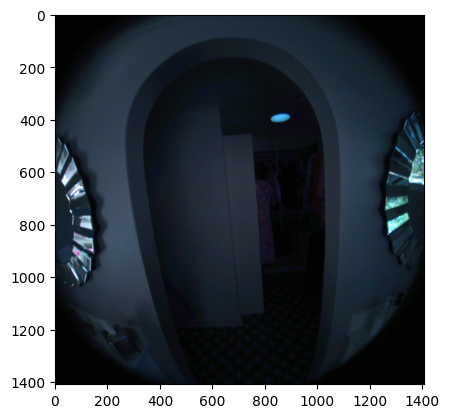

In [10]:
plt.imshow(np.rot90(rgb_images[0], k=-1))

In [11]:
def recognize_action(image_np):
    """
    Takes a numpy array image (H, W, 3 – RGB)
    Returns a string with VLM-predicted action.
    """
    torch.cuda.empty_cache()
    
    img = Image.fromarray(image_np)
    
    # Resize image to reduce memory usage
    max_size = 336 
    img.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)
    
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {
                    "type": "text", 
                    "text": "Analyze this image and describe it in one sentence following this pattern: Start with 'The human is', then add the action verb in -ing form (like 'opening', 'closing', 'picking'), then the main object, then desribe surroundings or context."
                },
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    
    inputs = processor(images=img, text=prompt, return_tensors="pt").to(model.device)
    
    with torch.inference_mode(): 
        output = model.generate(
            **inputs, 
            max_new_tokens=100, 
            do_sample=False,    
            num_beams=1 
        )
        result = processor.decode(output[0], skip_special_tokens=True)
    
    del inputs, output
    torch.cuda.empty_cache()
    
    return result

In [35]:
def recognize_activity(images_np):
    """
    Takes a numpy array image (N, H, W, 3) -> N rgb images
    Returns a string with VLM-predicted activity across span of N images
    """
    torch.cuda.empty_cache()
    
    images = [Image.fromarray(img_np) for img_np in images_np]
    
    max_size = 336 
    for img in images:
        img.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)
    
    content = []
    for _ in images:
        content.append({"type": "image"})
    
    content.append({
        "type": "text", 
        "text": "Look at these images in sequence and describe which activity is being performed across them."
    })
    
    conversation = [
        {
            "role": "user",
            "content": content
        },
    ]
    
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    
    inputs = processor(images=images, text=prompt, return_tensors="pt").to(model.device)
    
    with torch.inference_mode(): 
        output = model.generate(
            **inputs, 
            max_new_tokens=100, 
            do_sample=False,    
            num_beams=1 
        )
        result = processor.decode(output[0], skip_special_tokens=True)
    
    del inputs, output
    torch.cuda.empty_cache()
    
    return result

In [15]:
timestamps_ns = np.array(rgb_timestamps)

In [17]:
def get_every_nth_second_frame(timestamps_ns, n_seconds=1):
    timestamps_sec = (timestamps_ns - timestamps_ns[0]) / 1e9
    
    max_time = int(timestamps_sec[-1])
    target_times = np.arange(0, max_time + n_seconds + 1, n_seconds)
    
    sampled_indices = []
    for target in target_times:
        indexes= np.argmin(np.abs(timestamps_sec - target))
        sampled_indices.append(indexes)
    sampled_indices = sorted(set(sampled_indices))
    
    total_frames = len(timestamps_ns)
    sampled_frames = len(sampled_indices)
    percentage = (sampled_frames / total_frames) * 100
    
    print(f"Total frames: {total_frames}, sampled frames: {sampled_frames}, sampling each {int(total_frames/sampled_frames)}th frame, pct : {percentage:.2f}%")
    return np.array(sampled_indices)


samples = get_every_nth_second_frame(timestamps_ns, n_seconds=1)

Total frames: 339, sampled frames: 18, sampling each 18th frame, pct : 5.31%


In [18]:
rgb_images_to_select = [rgb_images[k] for k in samples] 

In [19]:
def action_annotate(images):
    actions = []
    for image in tqdm.tqdm(images, desc = "Actio annotating clip"):
        result = recognize_action(np.rot90(image, k=-1)) 
        action = result.split("ASSISTANT: ")[-1]
        actions.append(action)
    return actions

In [20]:
actions_in_a_clip = action_annotate(rgb_images_to_select)

Actio annotating clip: 100%|██████████| 18/18 [00:46<00:00,  2.56s/it]


In [21]:
actions_in_a_clip

['The human is opening the door to a dark room with a curved ceiling, where clothes are hanging on a rack.',
 'The human is holding a smartphone in a bathroom, capturing a photo of a toilet.',
 'The human is standing in a bathroom, opening a door to a bedroom.',
 'The human is opening the door to a bedroom with a bed, a chair, and a rug.',
 'The human is opening the door to the bedroom, which is filled with a large bed, a couch, and a rug.',
 'The human is opening the door to the room with a bed and a couch.',
 'The human is opening the door to a room with a couch, a chair, and a bed.',
 'The human is opening the door to a room with a bed, a window, and a view of a pink flower bush outside.',
 'The human is opening the door to a room with a window that offers a view of a patio with a potted plant and a chair.',
 'The human is opening the door, revealing a view of a garden with pink flowers and a blue tarp.',
 'The human is opening the door to a room with a view of a patio outside.',
 '

In [38]:
def activity_annotate(images, N_frames_for_activity=1):
    activities = []
    max_activities = int(len(images) / N_frames_for_activity)
    
    for i in tqdm.tqdm(range(max_activities), desc="Action annotating clip"):
        images_for_act = images[i*N_frames_for_activity:(i*N_frames_for_activity+N_frames_for_activity)]
        images_for_act = [np.rot90(img, k=-1) for img in images_for_act]
        result = recognize_activity(images_for_act) 
        activity = result.split("ASSISTANT: ")[-1]
        activities.append(activity)
    
    return activities

In [39]:
activity_in_a_clip = activity_annotate(rgb_images_to_select)

Action annotating clip:   0%|          | 0/18 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 2.75 MiB is free. Process 2470480 has 14.56 GiB memory in use. Of the allocated memory 14.35 GiB is allocated by PyTorch, and 90.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [34]:
activity_in_a_clip

["The images you've provided show a sequence of activities related to a room with a curved doorway. Here's a description of the activities as they appear in the sequence:\n\n1. The first image shows a person standing in the doorway, facing away from the camera. They appear to be entering or exiting the room.\n\n2. The second image shows the same person from a different angle, still in the doorway. They are now facing towards the camera,",
 "The image sequence shows a person holding a smartphone and taking a photo or recording a video of a bathroom. Here's the sequence of actions:\n\n1. The first image shows the person holding the phone, likely preparing to take a photo or record a video.\n2. The second image shows the phone being held steady, indicating that the person is in the process of capturing the image or video.\n3. The third image shows the phone still being held, suggesting",
 "The images show a sequence of activities in a bathroom. Here's the sequence and the activities being